# Neural Network Classifier & Regressor

In this tutorial we show how the `NeuralNetworkClassifier` and `NeuralNetworkRegressor` are used.
Both take as an input a (Quantum) `NeuralNetwork` and leverage it in a specific context.
In both cases we also provide a pre-configured variant for convenience, the Variational Quantum Classifier (`VQC`) and Variational Quantum Regressor (`VQR`). The tutorial is structured as follows:


1. [Classification](#Classification) 
    * Classification with an `EstimatorQNN`
    * Classification with a `SamplerQNN`
    * Variational Quantum Classifier (`VQC`)
    


In [1]:
!pip install qiskit-machine-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152 kB 20.7 MB/s 
     |████████████████████████████████| 4.8 MB 86.8 MB/s 
     |████████████████████████████████| 95 kB 5.3 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 929 kB 68.1 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 1.9 MB 72.7 MB/s 
     |████████████████████████████████| 112 kB 100.5 MB/s 
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [33]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.algorithms.optimizers import SLSQP, SPSA

from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

## Classification

We prepare a simple classification dataset to illustrate the following algorithms.

In [25]:
import csv
import os
import numpy as np
from sklearn.datasets import make_blobs
datafilename="BotnetDgaDataset_1000.csv"
resultname="result_BotnetDgaDataset_QNNEstimator_1000.txt"
cwd=os.getcwd()
mycsv=cwd+"/"+datafilename
print(mycsv)
def load_data(filepath):
    with open(filepath) as csv_file:
        data_file = csv.reader(csv_file)
        temp = next(data_file)
        n_samples = 1000
        n_features = 7
        data = np.empty((n_samples, n_features))
        target = np.empty((n_samples,), dtype=int)

        for i, ir in enumerate(data_file):
            data[i] = np.asarray(ir[:-1], dtype=np.float64)
            target[i] = np.asarray(ir[-1], dtype=int)

    return data, target
X, y = load_data(mycsv)
y01=y
print(X)
print(y)

/content/BotnetDgaDataset_1000.csv
[[2.75000000e+00 2.02395145e+00 1.68833892e+00 ... 1.20000000e+01
  8.28927094e-01 6.10289861e+01]
 [2.75000000e+00 1.34932404e+00 1.27629343e+00 ... 1.10000000e+01
  1.07095312e-01 5.03986659e+01]
 [2.94770278e+00 1.18356393e+00 1.04314566e+00 ... 1.20000000e+01
  1.07095312e-01 4.38894660e+01]
 ...
 [2.75000000e+00 2.27882381e+00 1.59106724e+00 ... 1.10000000e+01
  8.28927094e-01 2.20945536e+01]
 [3.03063906e+00 2.57658904e+00 6.44391656e-01 ... 2.00000000e+01
  8.28927094e-01 4.25845531e+01]
 [3.11827516e+00 9.13557521e-01 8.23459962e-01 ... 2.50000000e+01
  1.07095312e-01 1.78458415e+02]]
[0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1
 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 

In [26]:

num_inputs = 7
num_samples = 50
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1


### Classification with the an `EstimatorQNN`

First we show how an `EstimatorQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `EstimatorQNN` is expected to return one-dimensional output in $[-1, +1]$. This only works for binary classification and we assign the two classes to $\{-1, +1\}$.

In [7]:
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 24.7 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136833 sha256=7cf6fefe407f1c8337e5088500e9160a6aa192d6a5befac6e1fee8743c253009
  Stored in directory: /root/.cache/pip/wheels/72/99/be/81d9bcdf5dd5ee5acd8119a9dd5bc07204c9ce205fd341b021
Successfully built pylatexenc


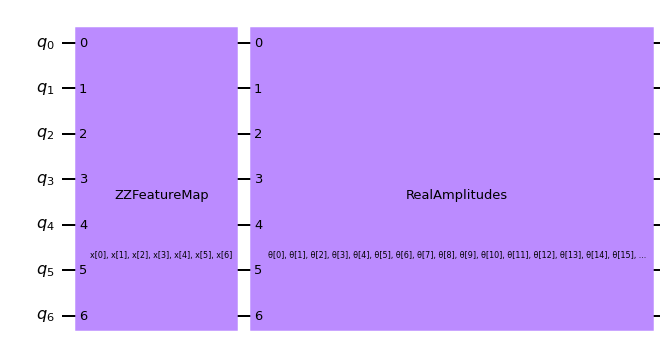

In [27]:
# construct QNN
qc = QuantumCircuit(7)
feature_map = ZZFeatureMap(7)
ansatz = RealAmplitudes(7)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

Create a quantum neural network

In [28]:
estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

In [29]:
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))
print (algorithm_globals.random.random(estimator_qnn.num_weights))

[0.38331982 0.72968571 0.55299307 0.93613999 0.78030149 0.47936956
 0.37635947 0.98663154 0.71776024 0.95119466 0.11847858 0.85053368
 0.63707388 0.12192168 0.588258   0.68609637 0.01230269 0.45431796
 0.82539951 0.29535903 0.45854808 0.44231413 0.30192739 0.9184419
 0.78129404 0.11058841 0.99703466 0.87920002]


We will add a callback function called `callback_graph`. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [30]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [34]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=SPSA(), callback=callback_graph
)

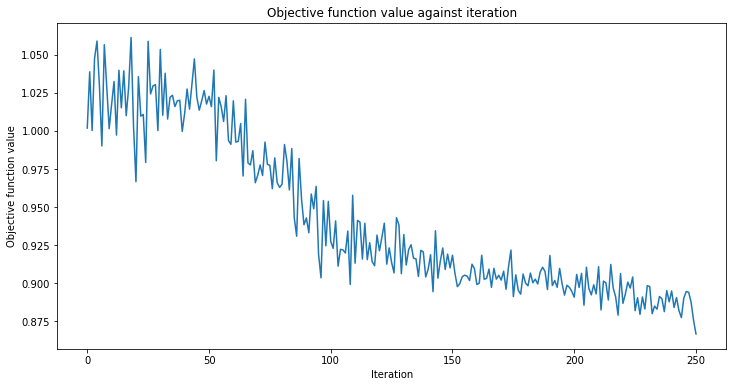

409.4188648439999


In [51]:
# create empty array for callback to store evaluations of the objective function
import time
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
start_estimator = time.perf_counter()
# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)
finish_estimator = time.perf_counter()
print(finish_estimator-start_estimator)

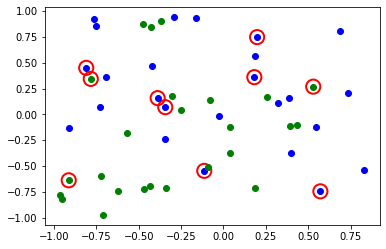

In [36]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.show()

Now, when the model is trained, we can explore the weights of the neural network. Please note, the number of weights is defined by ansatz.

In [37]:
estimator_classifier.weights


array([ 9.62724643e-01, -1.27598501e+00,  2.13529660e+00,  8.86308643e-01,
        5.07660751e+00,  1.44599765e+00,  4.60617026e+00,  2.42938230e+00,
       -3.06928387e-01, -3.19752581e+00, -6.45811000e-01,  3.42587067e+00,
        1.11190150e+00,  1.25097671e+00, -1.24026367e-01,  4.82776938e-01,
        4.15665253e-03, -3.97346573e+00,  3.85021902e-01, -1.61469736e+00,
       -3.83949774e-01,  1.22668838e+00,  1.80355758e+00, -6.56579663e-01,
        8.16439760e-01,  5.83807958e-01, -1.60179731e+00, -3.11886166e-01])

### Classification with a `SamplerQNN`

Next we show how a `SamplerQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `SamplerQNN` is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. 
The underlying `Sampler` primitive returns quasi-distributions of bit strings and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

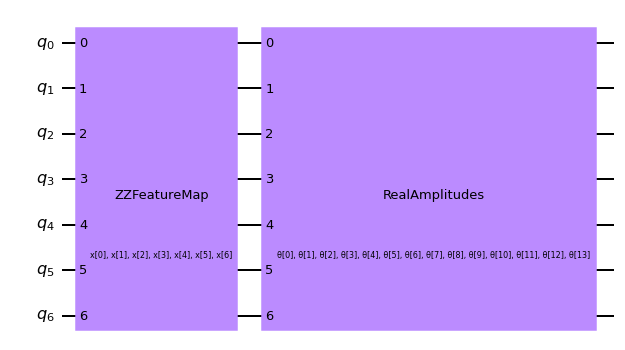

In [38]:
num_inputs=7
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")

In [39]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [40]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

In [41]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=SPSA(), callback=callback_graph
)

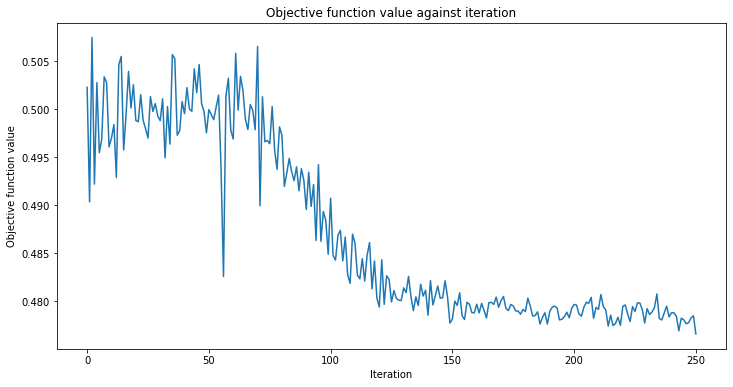

373.944117643


In [47]:
# create empty array for callback to store evaluations of the objective function
import time
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
start_sampler=time.perf_counter()
# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)
finish_sampler=time.perf_counter()
print(finish_sampler-start_sampler)

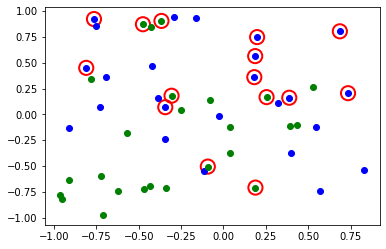

In [48]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.show()

Again, once the model is trained we can take a look at the weights. As we set `reps=1` explicitly in our ansatz, we can see less parameters than in the previous model.

In [49]:
sampler_classifier.weights

array([ 4.6270821 , -1.24113908,  0.64203225,  3.20969032, -1.68588892,
        0.68800587,  0.00730031, -0.23771973, -0.15870694,  1.55259084,
       -0.02957302, -2.04498273,  0.58937616,  1.92423035])

In [52]:
print("accuracy of QNN-Sampler=",sampler_classifier.score(X, y01))
print("accuracy of QNN-Estimator=", estimator_classifier.score(X, y))
print("tims(s) of QNN-Sampler=",finish_sampler-start_sampler)
print("tims(s) of QNN-Estimator=",finish_estimator-start_estimator)

accuracy of QNN-Sampler= 0.7
accuracy of QNN-Estimator= 0.84
tims(s) of QNN-Sampler= 373.944117643
tims(s) of QNN-Estimator= 409.4188648439999
